In [145]:
# Importing libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix, classification_report, r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

In [146]:
# Load the dataset
file_path = '/content/sample_data/test.burn_out.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score
0,fffe31003300390039003000,12/10/2008,Female,Service,No,2,5.0,7.7
1,fffe31003300310037003800,8/14/2008,Female,Product,Yes,1,2.0,5.2
2,fffe33003400380035003900,11/13/2008,Male,Product,Yes,1,3.0,5.9
3,fffe3100370039003200,2/7/2008,Female,Service,No,3,6.0,4.6
4,fffe32003600390036003700,7/17/2008,Female,Product,No,2,5.0,6.4


**Data Preparation**

In [147]:
# Check for missing values
print("Missing Values:\n", data.isnull().sum())

Missing Values:
 Employee ID               0
Date of Joining           0
Gender                    0
Company Type              0
WFH Setup Available       0
Designation               0
Resource Allocation     773
Mental Fatigue Score      0
dtype: int64


In [148]:
# Since Resource Allocation seems like an important feature, especially if it's related to employee performance,
# I decided to replace the missing values with the avarage value of all

data['Resource Allocation'].fillna(data['Resource Allocation'].mean(), inplace=True)

In [149]:
print("Missing Values:\n", data.isnull().sum())

Missing Values:
 Employee ID             0
Date of Joining         0
Gender                  0
Company Type            0
WFH Setup Available     0
Designation             0
Resource Allocation     0
Mental Fatigue Score    0
dtype: int64


In [150]:
print(data.dtypes)

Employee ID              object
Date of Joining          object
Gender                   object
Company Type             object
WFH Setup Available      object
Designation               int64
Resource Allocation     float64
Mental Fatigue Score    float64
dtype: object


In [151]:
# Identifying and reviewing any duplicate entries in the dataset
duplicate_rows = data[data.duplicated()]

# Print the duplicate rows if any exist
if not duplicate_rows.empty:
  print("Duplicate Rows:")
  print(duplicate_rows)
else:
  print("No duplicate rows found in the DataFrame.")

No duplicate rows found in the DataFrame.


In [152]:
# Clean the dataset by removing outliers from the 'Mental Fatigue Score' column
# Outlier detection (Example using IQR for 'Mental Fatigue Score')
Q1 = data['Mental Fatigue Score'].quantile(0.25)
Q3 = data['Mental Fatigue Score'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers in 'Mental Fatigue Score'
data = data[(data['Mental Fatigue Score'] >= lower_bound) & (data['Mental Fatigue Score'] <= upper_bound)]

# Display the cleaned dataset summary
cleaned_data_info = data.info()
cleaned_data_head = data.head()

# Display results
print("\nCleaned Data Info:\n", cleaned_data_info)
print("\nCleaned Data Head:\n", cleaned_data_head)

<class 'pandas.core.frame.DataFrame'>
Index: 12096 entries, 0 to 12249
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           12096 non-null  object 
 1   Date of Joining       12096 non-null  object 
 2   Gender                12096 non-null  object 
 3   Company Type          12096 non-null  object 
 4   WFH Setup Available   12096 non-null  object 
 5   Designation           12096 non-null  int64  
 6   Resource Allocation   12096 non-null  float64
 7   Mental Fatigue Score  12096 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 850.5+ KB

Cleaned Data Info:
 None

Cleaned Data Head:
                 Employee ID Date of Joining  Gender Company Type  \
0  fffe31003300390039003000      12/10/2008  Female      Service   
1  fffe31003300310037003800       8/14/2008  Female      Product   
2  fffe33003400380035003900      11/13/2008    Male      Product   
3   

In [153]:
# Frequencies for critical categorical variables
gender_freq = data['Gender'].value_counts()
company_type_freq = data['Company Type'].value_counts()
wfh_setup_freq = data['WFH Setup Available'].value_counts()

print("Gender Frequencies:\n", gender_freq)
print("Company Type Frequencies:\n", company_type_freq)
print("WFH Setup Frequencies:\n", wfh_setup_freq)


Gender Frequencies:
 Gender
Female    6351
Male      5745
Name: count, dtype: int64
Company Type Frequencies:
 Company Type
Service    7899
Product    4197
Name: count, dtype: int64
WFH Setup Frequencies:
 WFH Setup Available
Yes    6528
No     5568
Name: count, dtype: int64


In [154]:
# Get the statistical summary for numerical variables
numerical_summary = data.describe().T[['count', 'mean', 'std', 'min', '50%', 'max']].rename(columns={'count': 'Obs', '50%': 'Median'})
numerical_summary.columns = ['Obs', 'Mean', 'STD', 'Min', 'Median', 'Max']

print(numerical_summary)

                          Obs      Mean       STD  Min    Median   Max
Designation           12096.0  2.197173  1.121725  0.0  2.000000   5.0
Resource Allocation   12096.0  4.496918  1.956730  1.0  4.457524  10.0
Mental Fatigue Score  12096.0  5.791278  1.819888  0.7  5.900000  10.0


**Data Preprocessing**

In [155]:
# Create a binary variable for Mental Fatigue Score (1 if score > 6, else 0)
data['High Mental Fatigue'] = (data['Mental Fatigue Score'] > 6).astype(int)

# Define the features and target variable
# I excluded Employee ID from features because this is a unique identifier for each employee and does not hold any predictive value for the target variable.
# Including such columns can confuse the model as they don’t contribute to patterns or relationships related to the outcome.
# I excluded Date of Joining as well beacuse this is a date and may not directly help in the prediction

features = data[['Gender', 'Company Type', 'WFH Setup Available', 'Designation', 'Resource Allocation']]
target = data['High Mental Fatigue']


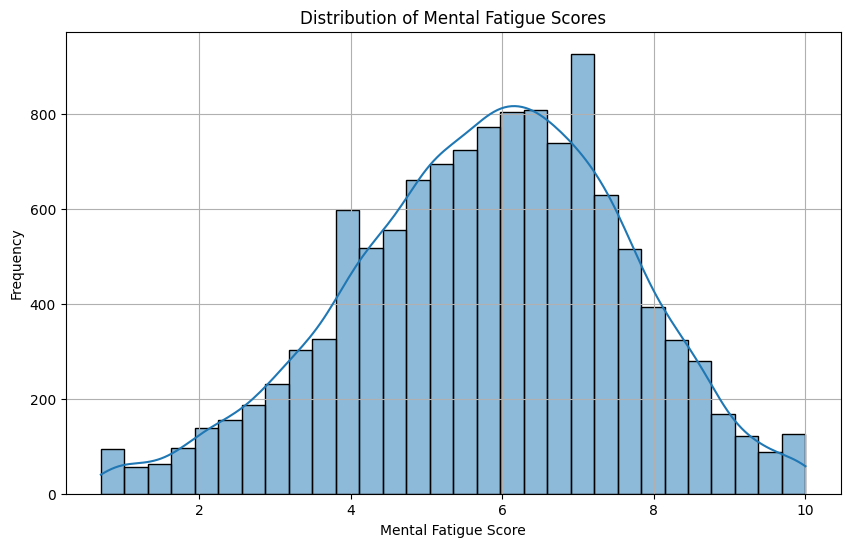

In [156]:
# Distribution of Mental Fatigue Scores

plt.figure(figsize=(10, 6))
sns.histplot(data['Mental Fatigue Score'], bins=30, kde=True)
plt.title('Distribution of Mental Fatigue Scores')
plt.xlabel('Mental Fatigue Score')
plt.ylabel('Frequency')
plt.grid()
plt.show()


In [ ]:
#  The majority of scores are centered around 5 to 6, with the frequency gradually decreasing as you move away from the center in both directions.
#  This implies that most employees have a moderate level of mental fatigue, while fewer employees exhibit extremely low (around 1-2) or extremely high (around 9-10) fatigue scores.

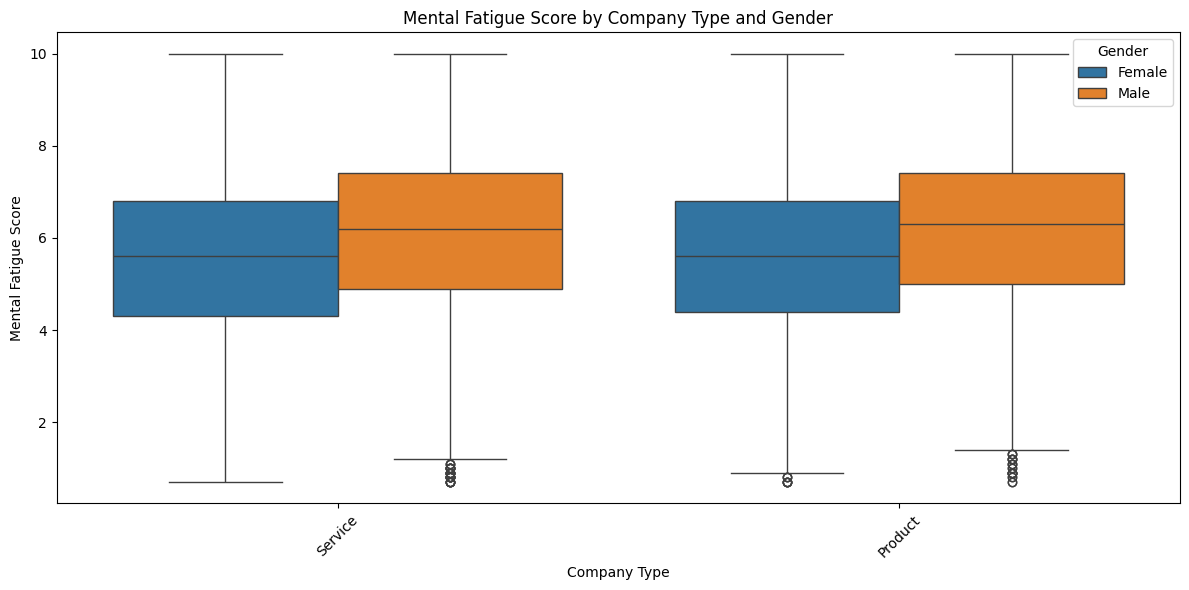

In [157]:
# Mental Fatigue Score by Gender and Company Type
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='Company Type', y='Mental Fatigue Score', hue='Gender')
plt.title('Mental Fatigue Score by Company Type and Gender')
plt.xticks(rotation=45)
plt.ylabel('Mental Fatigue Score')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

In [ ]:
# Females consistently report higher median mental fatigue scores than males in both company types.
# This analysis showes the importance of gender considerations in employee well-being initiatives.

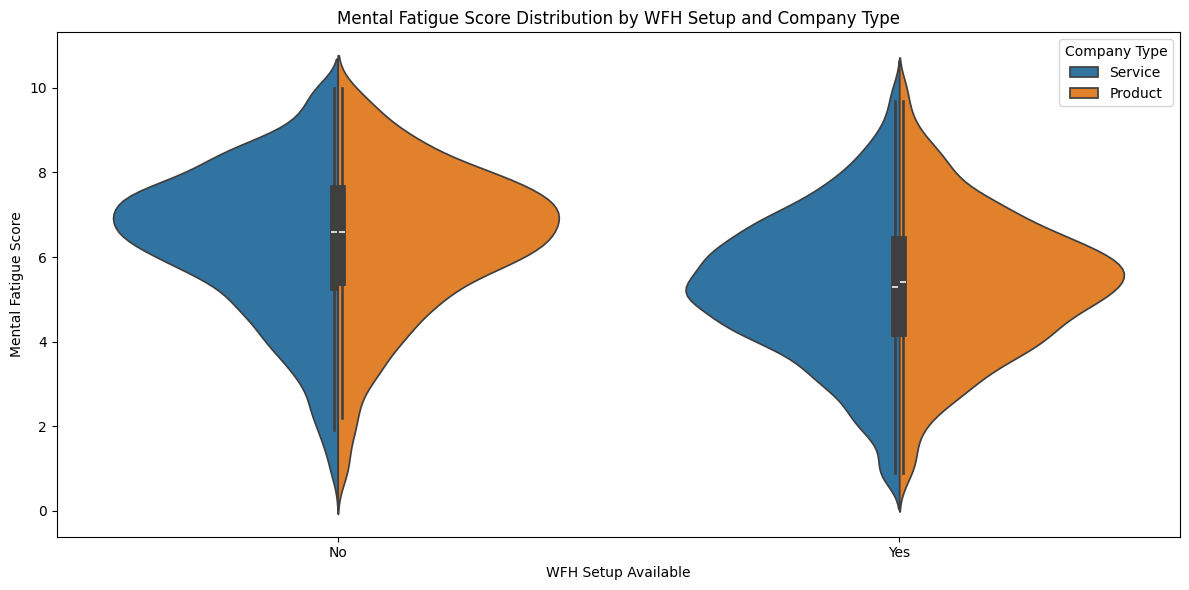

In [158]:
# Mental Fatigue Score Distribution by WFH Setup
plt.figure(figsize=(12, 6))
sns.violinplot(data=data, x='WFH Setup Available', y='Mental Fatigue Score', hue='Company Type', split=True)
plt.title('Mental Fatigue Score Distribution by WFH Setup and Company Type')
plt.ylabel('Mental Fatigue Score')
plt.xlabel('WFH Setup Available')
plt.tight_layout()
plt.show()


In [ ]:
# The Service sector shows a broader distribution of scores without WFH, indicating varied fatigue levels, while the Product sector demonstrates more uniform scores.
# Both sectors benefit from WFH, with lower fatigue scores observed for employees with this option.
# These results suggest that implementing flexible work arrangements could help reduce mental fatigue, particularly in the Service sector.

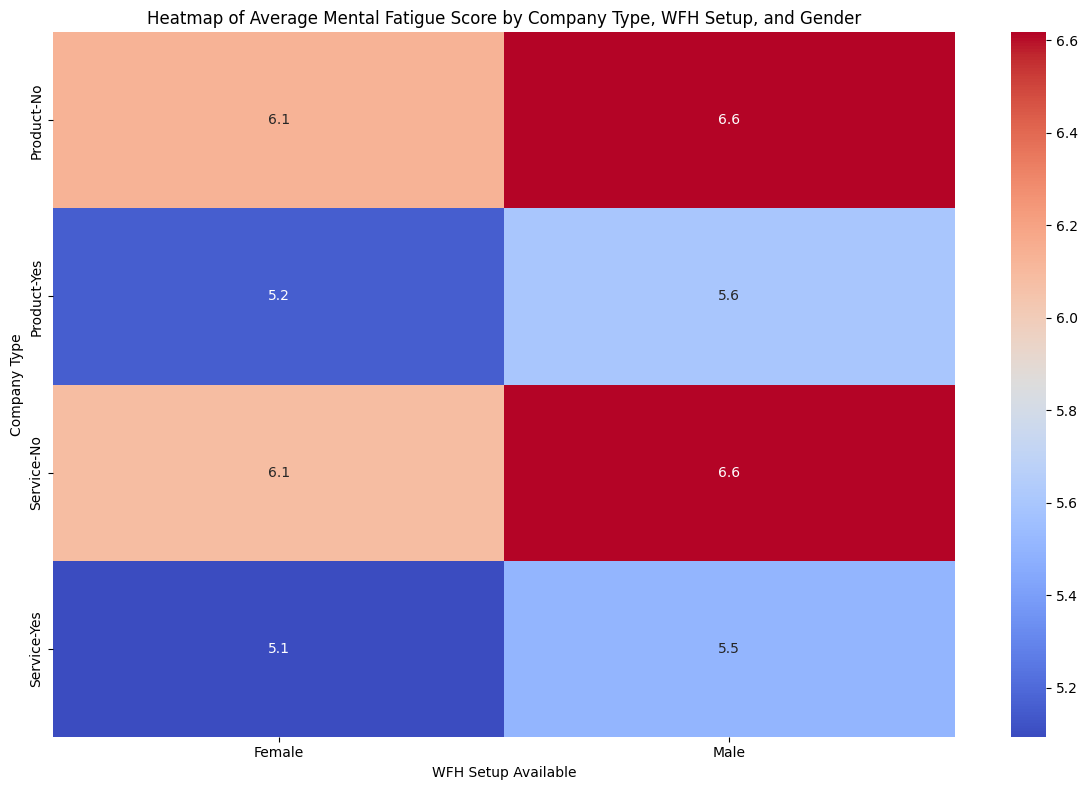

In [159]:
# Heatmap showing correlation between Mental Fatigue Score and other categorical variables
plt.figure(figsize=(12, 8))
heatmap_data = data.groupby(['Company Type', 'WFH Setup Available', 'Gender'])['Mental Fatigue Score'].mean().unstack()
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Heatmap of Average Mental Fatigue Score by Company Type, WFH Setup, and Gender')
plt.ylabel('Company Type')
plt.xlabel('WFH Setup Available')
plt.tight_layout()
plt.show()

In [ ]:
# The heatmap illustrates the average Mental Fatigue Scores categorized by Company Type (Service and Product), WFH Setup (Yes/No), and Gender.
# Female employees in the Product sector without WFH have the highest average score (6.6), indicating greater mental fatigue.
# Males in the Service sector with WFH show lower fatigue (5.1) compared to their female counterparts (5.6).
# These results suggest that gender, company type, and work-from-home arrangements significantly influence mental fatigue, highlighting the need for customized support strategies in the workplace.

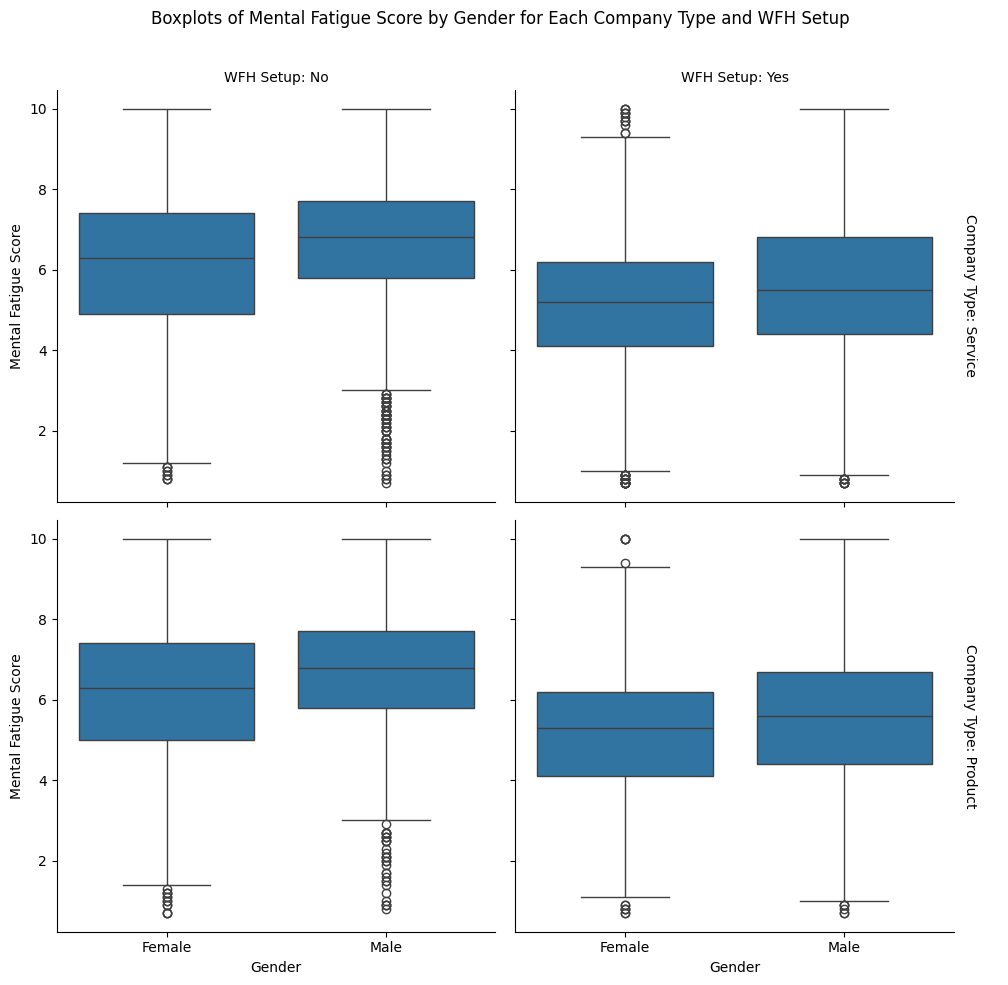

In [160]:
# FacetGrid to create multiple plots for Mental Fatigue Score by Company Type and WFH Setup
g = sns.FacetGrid(data, col='WFH Setup Available', row='Company Type', margin_titles=True, height=5)
g.map(sns.boxplot, 'Gender', 'Mental Fatigue Score')
g.add_legend()
g.set_axis_labels('Gender', 'Mental Fatigue Score')
g.set_titles(col_template='WFH Setup: {col_name}', row_template='Company Type: {row_name}')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Boxplots of Mental Fatigue Score by Gender for Each Company Type and WFH Setup')
plt.show()

In [ ]:
# The boxplots depict Mental Fatigue Scores categorized by Gender, Company Type (Service and Product), and WFH Setup (Yes/No).
# In the Service sector without WFH, both genders show higher median scores, with more variability and outliers, particularly among females.
# With WFH, both genders experience lower fatigue scores in the Product sector, but the median scores remain higher for females.
# These results indicate that WFH arrangements positively impact mental fatigue, especially in the Product sector,
# while highlighting the need for targeted interventions in the Service sector to address higher fatigue levels among female employees.

In [161]:
# Prepearing for the Correlation Heatmap
# create a subset with only numerical columns

# Select only numerical columns
numerical_subset = data.select_dtypes(include=np.number)

# Display the numerical subset
print(numerical_subset.head())

   Designation  Resource Allocation  Mental Fatigue Score  High Mental Fatigue
0            2                  5.0                   7.7                    1
1            1                  2.0                   5.2                    0
2            1                  3.0                   5.9                    0
3            3                  6.0                   4.6                    0
4            2                  5.0                   6.4                    1


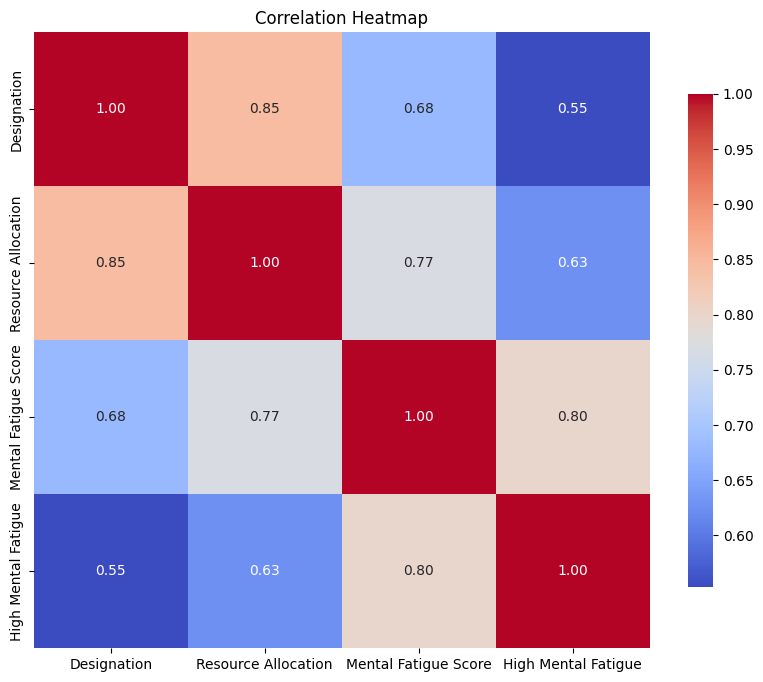

In [162]:
# Convert categorical variables to numeric using one-hot encoding
df_encoded = pd.get_dummies(numerical_subset, drop_first=True)

# Calculate the correlation matrix
correlation_matrix = df_encoded.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Title and display the heatmap
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# The correlation heatmap displays the relationships among Designation, Resource Allocation, Mental Fatigue Score, and High Mental Fatigue.
# Strong correlations are observed between Designation and Resource Allocation (0.85) and between Mental Fatigue Score and High Mental Fatigue (0.80).
# There is a notable correlation between Resource Allocation and Mental Fatigue Score (0.77), suggesting that increased resource allocation may influence fatigue levels.
# These findings indicate that employee roles and available resources significantly impact mental fatigue,
# highlighting areas for targeted improvements in resource management to enhance employee well-being.

**Linear Regression Model**

In [163]:
# Features (X) and target (y)
data['Gender'] = [1 if (gender == 'Male') else 0 for gender in data['Gender']]
data['Company Type'] = [1 if (company == 'Product') else 0 for company in data['Company Type']]
data['WFH Setup Available'] = [1 if (wfh == 'Yes') else 0 for wfh in data['WFH Setup Available']]

X = data[['Gender', 'Company Type', 'WFH Setup Available', 'Designation', 'Resource Allocation']]
y = data['High Mental Fatigue']


In [165]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [166]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [167]:
# Output the results
print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

Mean Squared Error: 0.14375261540456497
R-squared: 0.42400600926704
Coefficients: [ 0.0583695   0.00033288 -0.13243091  0.04366705  0.12689912]
Intercept: -0.1573353045541811


In [ ]:
 # The results indicate a basic understanding of the relationships, but improvements in model accuracy are difficult given the amount and type of data in our hand.
 # The predictive factors with a 42.4% of the variance in the dependent variable is explained by the model

**Logistic Regression Model**

In [168]:
# Preprocessing pipeline: One-hot encoding for categorical variables

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['Gender', 'Company Type', 'WFH Setup Available', 'Designation'])
    ]
)


In [169]:
# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [170]:
# Create a logistic regression model pipeline

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])


In [171]:
# Fit the model

model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['Gender', 'Company Type',
                                                   'WFH Setup Available',
                                                   'Designation'])])),
                ('classifier', LogisticRegression())])

In [172]:
# Make predictions

y_pred = model.predict(X_test)


In [173]:
# Evaluate the model

conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

conf_matrix, class_report

(array([[957, 303],
        [293, 867]]),
 '              precision    recall  f1-score   support\n\n           0       0.77      0.76      0.76      1260\n           1       0.74      0.75      0.74      1160\n\n    accuracy                           0.75      2420\n   macro avg       0.75      0.75      0.75      2420\nweighted avg       0.75      0.75      0.75      2420\n')

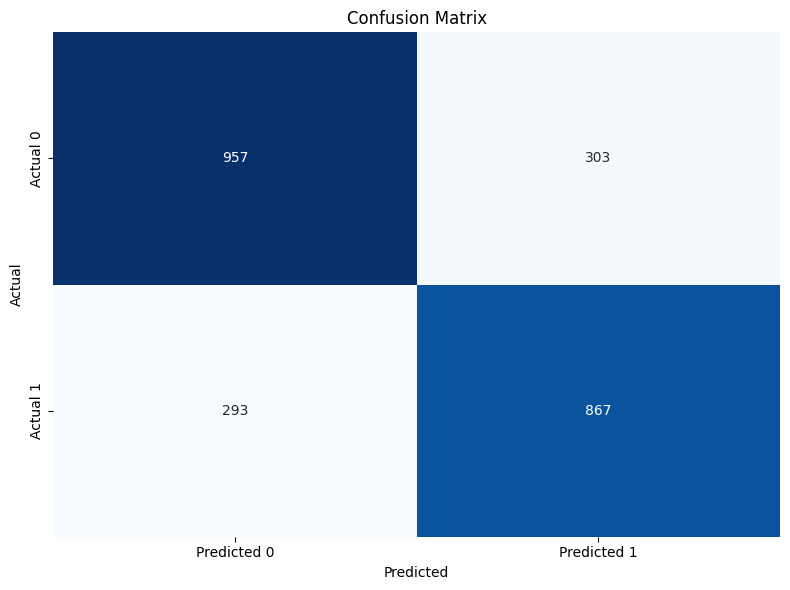

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.76      0.76      1260
           1       0.74      0.75      0.74      1160

    accuracy                           0.75      2420
   macro avg       0.75      0.75      0.75      2420
weighted avg       0.75      0.75      0.75      2420



In [174]:
# Create a confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Print the classification report
print("Classification Report:\n", class_report)


In [ ]:
# The model has a strong performance with a high number of true negatives and true positives, but the false positive rate is relatively high.

In [76]:
# We can conclude that for 2 different approaches we have 2 different results, given the quality of the data in our hand.
# Therefore Linear Regression Model presents a lower result of accuracy compared to Logistic Regression Model with an accuracy of 75% that is a solid performance in classification
# In the Linear Regression Model the MSE is relatively low, indicating reasonable accuracy in predictions.
# So the model performs better when classifies data than when it predicts.